# Recommendation for Restaurant in Toronto, Canada

#### FourSquare API Credentials 

In [187]:
CLIENT_ID = 'SCABUNIKWKU31CGS5SVE5K205CFIPX0BZQHPEX0ZZAKVPVDD'
CLIENT_SECRET = 'PTR2M1M1TLBPO02RYTMVTN5RIV5WS30VAFRCWMU051HKLPJZ'
VERSION ='20180323'

#### Importing Required libaray


In [188]:
# numpy for data vectors
import numpy as np

# pandas for data analysis
import pandas as pd

# transform json into pandas dataframe
from pandas.io.json import json_normalize

# requests the Url 
import requests

#nominatim to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim


# import k-means from clustering stage
from sklearn.cluster import KMeans

# folium for visualizaing maps
import folium

#grocoder find the longitude and latitude from the address  
import geocoder

### Data Acquisition of Canada Postal Code

Postal code and borough data collect from the 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

In [222]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_html = requests.get(url).content
postal_df = pd.read_html(wiki_html)[0]
postal_df.columns = ['PostalCode', 'Borough', 'Neighborhood'] #rename columns
postal_df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,NaN
1,M2A,Not assigned,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [190]:
print(postal_df.shape[0],'Records')

180 Records


### Cleaning the Data 

Checking the null value

In [191]:
postal_df.isna().sum(axis = 0)

PostalCode       0
Borough          0
Neighborhood    77
dtype: int64

### Removing the Not assign in Borough

In [192]:
postal_df = postal_df[postal_df['Borough'] != 'Not assigned']

In [193]:
postal_df.isna().sum(axis = 0)

PostalCode      0
Borough         0
Neighborhood    0
dtype: int64

Geocoder library 'https://pypi.org/project/geocoder/' used to get longitude and latitude of each postalcode.

It need google cloud credential 

In [195]:
# import geocoder
# latitude = []
# longitude = []
# for elem in postal_df['PostalCode']:
# # initialize your variable to None
#     lat_lng_coords = None

# # loop until you get the coordinates
#     while (lat_lng_coords is None):
#         g = geocoder.google('{}, Toronto, Ontario'.format(elem))
#         lat_lng_coords = g.latlng
#         # print(lat_lng_coords)

#     latitude.append(lat_lng_coords[0])
#     longitude.append(lat_lng_coords[1])
#     print(elem, 'is RECEIVED.')

'Geospatial_Coordinates.csv' have the coordinates from of each postalcode which get from the geocoder library

In [196]:
df_geo = pd.read_csv('Geospatial_Coordinates.csv')
df_geo.columns=('PostalCode','Latitude','Longitude')

Merging the longitude and latitude of each neighbourhood

In [197]:
postal_df = pd.merge(postal_df, df_geo)
postal_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


We decide to work only the center of the Toronto by identifying the borough which contains the Name Toronto


In [198]:
toronto_data = postal_df[postal_df['Borough'].str.contains('Toronto')].reset_index(drop=True)
print(toronto_data['Borough'].value_counts())
toronto_data.head(10)

Downtown Toronto    19
Central Toronto      9
West Toronto         6
East Toronto         5
Name: Borough, dtype: int64


,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259


Identify the center of the Toronto City by finding the longitude and latitude with the geolocatar library

In [199]:
geolocator = Nominatim(user_agent="explorer")
location = geolocator.geocode('Toronto, Ontario')
latitude = location.latitude
longitude = location.longitude
print(f'The longitude and latitude of Toronto, Ontario are {latitude} , { longitude}')

The longitude and latitude of Toronto, Ontario are 43.6534817 , -79.3839347


### Create map using latitude and longitude values of the neighbourhood with the 'folium libaray' 

circle respresent the neigbourhood when we click on circle we can see the detail of the neighbourhood

In [200]:

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for postalcode, borough, neighborhood, lat, long in zip(toronto_data['PostalCode'], 
                                                        toronto_data['Borough'], 
                                                        toronto_data['Neighborhood'], 
                                                        toronto_data['Latitude'], 
                                                        toronto_data['Longitude']):
    label = '%s, (%s), %s' % (postalcode, neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=10,
        popup=label,
        fill=True,
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## Exploring Neighbourhood

'getNearbyVenues' is used to request the Fouresquare API for the venues by providing the longitude and latitude 

In [201]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, limit=10):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
      
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Origin', 
                  'Origin Latitude', 
                  'Origin Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [202]:
toronto_venues = getNearbyVenues(names=toronto_data['PostalCode'],
                                 latitudes=toronto_data['Latitude'],
                                 longitudes=toronto_data['Longitude'],
                                 radius=1000,
                                 limit=100
                                  )

In [203]:
print(toronto_venues.shape)
toronto_venues.head()

(3190, 7)


,Origin,Origin Latitude,Origin Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
3,M5A,43.65426,-79.360636,The Distillery Historic District,43.650244,-79.359323,Historic Site
4,M5A,43.65426,-79.360636,Corktown Common,43.655618,-79.356211,Park


Unique Categories in the neighbourhood 

In [204]:
unique=toronto_venues['Venue Category'].unique()
len(unique)

277

Unique restaurant categories in the neighbourhood 

In [205]:
restaurant_data = toronto_venues[toronto_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
print(len(restaurant_data['Venue Category'].unique()))

52


In [206]:
print(restaurant_data['Venue Category'].unique())

['Restaurant' 'Mediterranean Restaurant' 'Italian Restaurant'
 'French Restaurant' 'Thai Restaurant' 'German Restaurant'
 'Mexican Restaurant' 'Asian Restaurant' 'Middle Eastern Restaurant'
 'Sushi Restaurant' 'Pakistani Restaurant' 'Indian Restaurant'
 'Ramen Restaurant' 'Vegetarian / Vegan Restaurant' 'Theme Restaurant'
 'Modern European Restaurant' 'Japanese Restaurant' 'Ethiopian Restaurant'
 'Caribbean Restaurant' 'Fast Food Restaurant' 'American Restaurant'
 'New American Restaurant' 'Seafood Restaurant' 'Comfort Food Restaurant'
 'Greek Restaurant' 'South American Restaurant' 'Korean Restaurant'
 'Latin American Restaurant' 'Eastern European Restaurant'
 'Jewish Restaurant' 'Vietnamese Restaurant' 'Chinese Restaurant'
 'Brazilian Restaurant' 'Portuguese Restaurant' 'Cuban Restaurant'
 'Tapas Restaurant' 'Dumpling Restaurant' 'Turkish Restaurant'
 'Falafel Restaurant' 'Hawaiian Restaurant' 'Tibetan Restaurant'
 'North Indian Restaurant' 'Indian Chinese Restaurant'
 'Persian Resta

<BarContainer object of 52 artists>

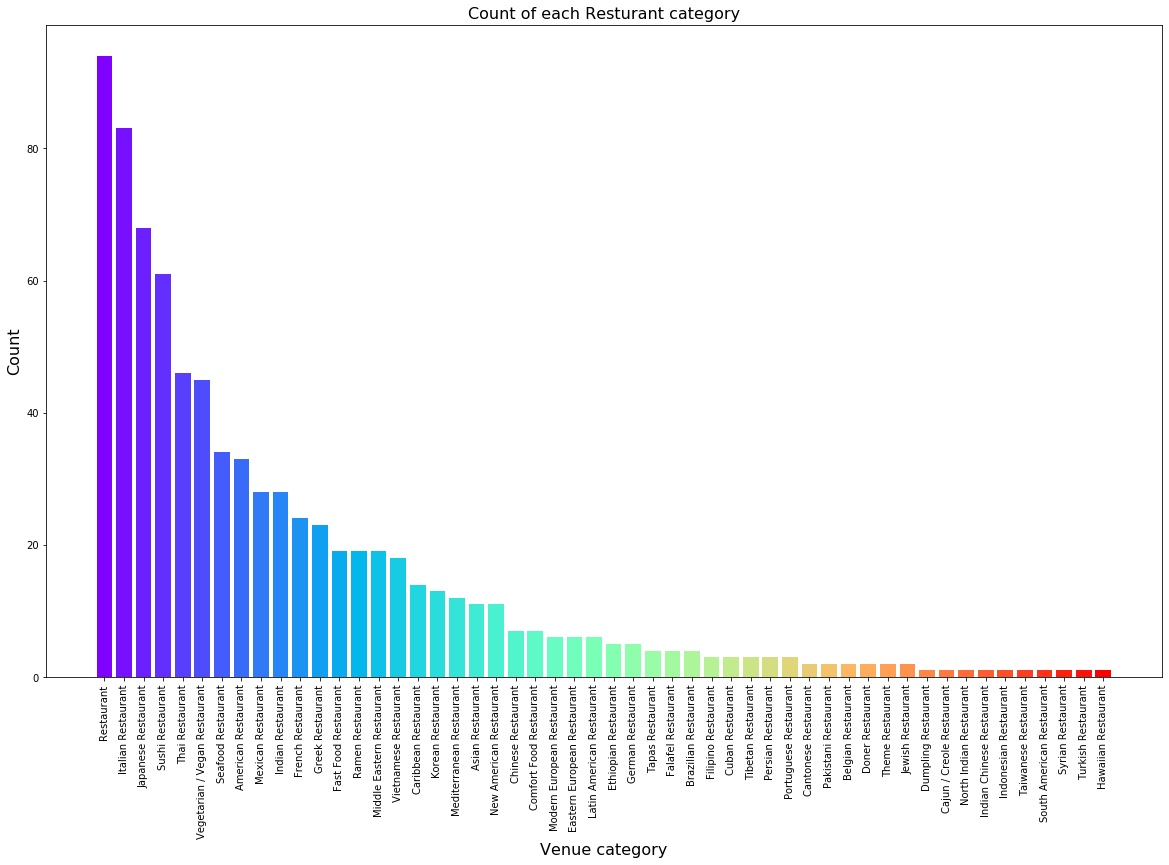

In [207]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

venue_distribution = restaurant_data['Venue Category'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of each Resturant category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

In [208]:
restaurant_data.head()

,Origin,Origin Latitude,Origin Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant
1,M5A,43.65426,-79.360636,Souk Tabule,43.653756,-79.354390,Mediterranean Restaurant
2,M5A,43.65426,-79.360636,Mangia and Bevi Resto-Bar,43.652250,-79.366355,Italian Restaurant
3,M5A,43.65426,-79.360636,Cluny Bistro & Boulangerie,43.650565,-79.357843,French Restaurant
4,M5A,43.65426,-79.360636,Sukhothai,43.658444,-79.365681,Thai Restaurant


### Total Number of Resturants at each Origin 

In [209]:
restaurant_data[['Origin','Venue']].groupby('Origin').count()

,Venue
Origin,
M4E,15
M4K,34
M4L,22
M4M,27
M4P,24
M4R,11
M4S,37
M4T,19
M4V,24


### Analyse each Neighbourhood

In [210]:
# one hot encoding categories
toronto_onehot = pd.get_dummies(restaurant_data[['Venue Category']], prefix="", prefix_sep="")

# add postal code column back to dataframe
toronto_onehot['PostalCode'] = restaurant_data['Origin'] 

# move postal code column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,PostalCode,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,...,Sushi Restaurant,Syrian Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,M5A,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [211]:
toronto_onehot.shape

(794, 53)

#### Next, let's group rows by postal code, taking the mean of the frequency of occurrence of each category

In [212]:
toronto_grouped = toronto_onehot.groupby('PostalCode').mean().reset_index()
toronto_grouped

,PostalCode,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Comfort Food Restaurant,...,Sushi Restaurant,Syrian Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
0,M4E,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000
1,M4K,0.029412,0.029412,0.000000,0.000000,0.000000,0.000000,0.029412,0.029412,0.000000,...,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000
2,M4L,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.000000
3,M4M,0.148148,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.037037,0.037037,...,0.074074,0.000000,0.000000,0.000000,0.074074,0.000000,0.000000,0.000000,0.037037,0.148148
4,M4P,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,...,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.041667,0.041667
5,M4R,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,...,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909
6,M4S,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027027,0.000000,0.000000,...,0.162162,0.027027,0.000000,0.000000,0.027027,0.000000,0.000000,0.000000,0.027027,0.027027
7,M4T,0.052632,0.000000,0.000000,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,...,0.105263,0.000000,0.000000,0.000000,0.157895,0.000000,0.000000,0.000000,0.000000,0.052632
8,M4V,0.041667,0.000000,0.000000,0.000000,0.000000,0.041667,0.000000,0.000000,0.000000,...,0.208333,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.041667,0.041667
9,M4W,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [213]:
toronto_grouped.shape

(38, 53)

In [214]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Filter the top 10 restaurant category venues

In [215]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['PostalCode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
venues_sorted = pd.DataFrame(columns=columns)
venues_sorted['PostalCode'] = toronto_grouped['PostalCode']

for ind in np.arange(toronto_grouped.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

venues_sorted.head()

,PostalCode,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,M4E,Japanese Restaurant,Caribbean Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Greek Restaurant,French Restaurant,Mediterranean Restaurant,Mexican Restaurant,Restaurant
1,M4K,Greek Restaurant,Italian Restaurant,Fast Food Restaurant,Ramen Restaurant,Restaurant,American Restaurant,Chinese Restaurant,Falafel Restaurant,New American Restaurant,Portuguese Restaurant
2,M4L,Indian Restaurant,Fast Food Restaurant,Restaurant,Japanese Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,French Restaurant,Middle Eastern Restaurant,Pakistani Restaurant,Indian Chinese Restaurant
3,M4M,Vietnamese Restaurant,American Restaurant,Italian Restaurant,French Restaurant,Thai Restaurant,Latin American Restaurant,Sushi Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant
4,M4P,Italian Restaurant,Restaurant,Fast Food Restaurant,Sushi Restaurant,Mexican Restaurant,Vietnamese Restaurant,Seafood Restaurant,Chinese Restaurant,Greek Restaurant,Vegetarian / Vegan Restaurant


### Clustering 

Cluster the venues with k-mean clustering 

In [231]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('PostalCode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)


In [232]:
kmeans.labels_

array([0, 2, 2, 2, 2, 2, 2, 2, 2, 3, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       2, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2])

### Cluster label add to the dataset

In [218]:
# add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_data.join(venues_sorted.set_index('PostalCode'), on='PostalCode')

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2.0,Restaurant,Italian Restaurant,Indian Restaurant,Sushi Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Mediterranean Restaurant,Pakistani Restaurant,French Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2.0,Sushi Restaurant,Japanese Restaurant,Thai Restaurant,Ramen Restaurant,Italian Restaurant,Restaurant,Middle Eastern Restaurant,Indian Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0.0,Japanese Restaurant,Restaurant,Italian Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Seafood Restaurant,Fast Food Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0.0,Restaurant,Seafood Restaurant,Italian Restaurant,Japanese Restaurant,American Restaurant,Thai Restaurant,New American Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,French Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0.0,Japanese Restaurant,Caribbean Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Greek Restaurant,French Restaurant,Mediterranean Restaurant,Mexican Restaurant,Restaurant


In [219]:
toronto_merged=toronto_merged.dropna()
#toronto_merged['Cluster Labels'].astype(int)
toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].astype(int)
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Restaurant,Italian Restaurant,Indian Restaurant,Sushi Restaurant,Thai Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Mediterranean Restaurant,Pakistani Restaurant,French Restaurant
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Sushi Restaurant,Japanese Restaurant,Thai Restaurant,Ramen Restaurant,Italian Restaurant,Restaurant,Middle Eastern Restaurant,Indian Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Japanese Restaurant,Restaurant,Italian Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Seafood Restaurant,Fast Food Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Restaurant,Seafood Restaurant,Italian Restaurant,Japanese Restaurant,American Restaurant,Thai Restaurant,New American Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,French Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Japanese Restaurant,Caribbean Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Greek Restaurant,French Restaurant,Mediterranean Restaurant,Mexican Restaurant,Restaurant


## Visualize the cluster

visualize the cluster on the map with foluim library 

In [221]:
# Matplotlib for plotting
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as py
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.Set1(np.linspace(0, 1, 9)) # Set1 color map has 9 colors
color_map = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, postalcode, borough, neighbor, cluster, first in zip(
    toronto_merged['Latitude'], 
    toronto_merged['Longitude'], 
    toronto_merged['PostalCode'], 
    toronto_merged['Borough'], 
    toronto_merged['Neighborhood'],
    toronto_merged['Cluster Labels'],
    toronto_merged['1st Most Common Restaurant']):
    label = folium.Popup( '%s (%s: %s). \nCluster %i. \n%s' % (postalcode, borough, neighbor, cluster+1, first), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color_map[cluster%9],
        fill=True,
        fill_color=color_map[cluster%9],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analyse each cluster separetly 

In [243]:
cluster0 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]
cluster0

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0,Japanese Restaurant,Restaurant,Italian Restaurant,Middle Eastern Restaurant,Ramen Restaurant,Seafood Restaurant,Fast Food Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Restaurant,Seafood Restaurant,Italian Restaurant,Japanese Restaurant,American Restaurant,Thai Restaurant,New American Restaurant,German Restaurant,Vegetarian / Vegan Restaurant,French Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Japanese Restaurant,Caribbean Restaurant,Asian Restaurant,Vegetarian / Vegan Restaurant,Thai Restaurant,Greek Restaurant,French Restaurant,Mediterranean Restaurant,Mexican Restaurant,Restaurant
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Japanese Restaurant,Restaurant,Seafood Restaurant,Comfort Food Restaurant,French Restaurant,Greek Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Middle Eastern Restaurant,New American Restaurant
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0,Japanese Restaurant,Ramen Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Sushi Restaurant,Restaurant,Seafood Restaurant,Fast Food Restaurant
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564,0,Korean Restaurant,Mexican Restaurant,Japanese Restaurant,Ethiopian Restaurant,Indian Restaurant,Vegetarian / Vegan Restaurant,Ramen Restaurant,Caribbean Restaurant,Chinese Restaurant,Eastern European Restaurant
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0,Restaurant,Japanese Restaurant,Sushi Restaurant,Seafood Restaurant,American Restaurant,Thai Restaurant,Ramen Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant
10,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,0,Japanese Restaurant,Vegetarian / Vegan Restaurant,Restaurant,Chinese Restaurant,Italian Restaurant,Greek Restaurant,French Restaurant,Mediterranean Restaurant,Seafood Restaurant,Indian Restaurant
11,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,0,Restaurant,Vegetarian / Vegan Restaurant,Asian Restaurant,Italian Restaurant,Vietnamese Restaurant,Seafood Restaurant,Japanese Restaurant,American Restaurant,Dumpling Restaurant,French Restaurant
13,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,0,Japanese Restaurant,Restaurant,Seafood Restaurant,Thai Restaurant,Vegetarian / Vegan Restaurant,American Restaurant,New American Restaurant,Asian Restaurant,Sushi Restaurant,Brazilian Restaurant


In [241]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.Set1(np.linspace(0, 1, 9)) # Set1 color map has 9 colors
color_map = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, postalcode, borough, neighbor, cluster, first, second, third in zip(
    cluster0['Latitude'], 
    cluster0['Longitude'], 
    cluster0['PostalCode'], 
    cluster0['Borough'], 
    cluster0['Neighborhood'],
    cluster0['Cluster Labels'],
    cluster0['1st Most Common Restaurant'],
    cluster0['2nd Most Common Restaurant'],
    cluster0['3rd Most Common Restaurant']):
    label = folium.Popup( '%s (%s: %s). \nCluster %i. \n%s %s and %s' % (postalcode, borough, neighbor, cluster+1, first, second, third), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color_map[cluster%9],
        fill=True,
        fill_color=color_map[cluster%9],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


In [244]:
cluster1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1]
cluster1

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
32,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.39442,1,Sushi Restaurant,Vietnamese Restaurant,Eastern European Restaurant,Indian Restaurant,Indian Chinese Restaurant,Hawaiian Restaurant,Greek Restaurant,German Restaurant,French Restaurant,Filipino Restaurant


In [245]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.Set1(np.linspace(0, 1, 9)) # Set1 color map has 9 colors
color_map = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, postalcode, borough, neighbor, cluster, first, second, third in zip(
    cluster1['Latitude'], 
    cluster1['Longitude'], 
    cluster1['PostalCode'], 
    cluster1['Borough'], 
    cluster1['Neighborhood'],
    cluster1['Cluster Labels'],
    cluster1['1st Most Common Restaurant'],
    cluster1['2nd Most Common Restaurant'],
    cluster1['3rd Most Common Restaurant']):
    label = folium.Popup( '%s (%s: %s). \nCluster %i. \n%s %s and %s' % (postalcode, borough, neighbor, cluster+1, first, second, third), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=color_map[cluster%9],
        fill=True,
        fill_color=color_map[cluster%9],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters
